In [1]:
import pandas as pd
import plotly.express as px

# For investigating timeseries data
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Modeling
from tqdm import tqdm
from itertools import product

### Importing + Visualizing Data

In [2]:
df = pd.read_csv('./Data/adidas_revenue1.csv')
target_varaible = 'Revenue'
df.head(5)

,Revenue,US GDP,Europe GDP,CHN GDP US,Price Index,NIKE,quarter
0,1517,12359.095,1728.2440,257.649148,246.5,2161.6,12/31/2006
1,1248,12592.530,1749.6000,290.437535,326.4,2272.7,3/31/2007
2,1677,12607.676,1769.2586,310.550979,322.5,2636.7,6/30/2007
3,1393,12679.338,1789.2533,352.695291,321.0,2198.7,9/30/2007
4,1558,12643.283,1819.1398,290.974546,329.4,2170.1,12/31/2007


In [3]:
# Graphing data
fig = px.line(df, x = 'quarter', y = target_varaible,
              title = 'Customer Inventory Over Time')
fig.show()

### Checking if Data is Stationary

In [4]:
dftest = adfuller(df[target_varaible])

# Printing results
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: 1.258540
p-value: 0.996366
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592


P-value is greater than 0.05 so data is not stationary, need to difference

In [5]:
target_variable_transformed = target_varaible
df[target_variable_transformed] = df[target_varaible]
# Graphing data
fig = px.line(df, x = 'quarter', y = target_variable_transformed,
              title = 'transformed_inventory Over Time')
fig.show()

In [6]:
dftest = adfuller(df[target_variable_transformed].dropna())

# Printing results
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: 1.258540
p-value: 0.996366
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592


### Now Fitting Moving Average (MA) model

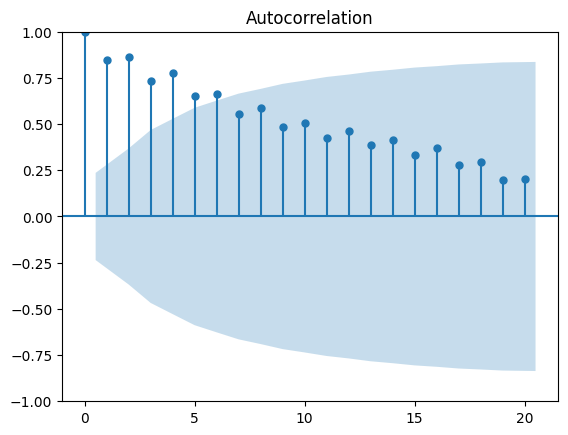

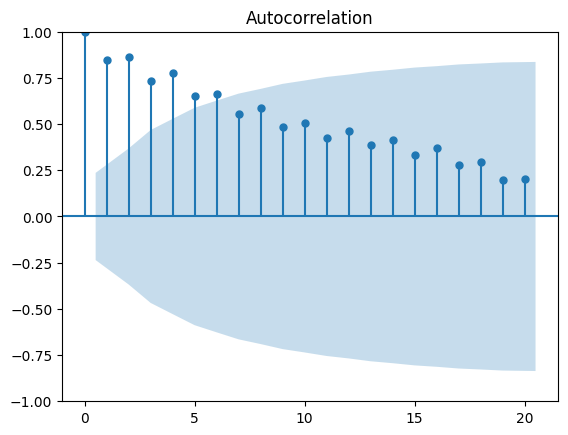

In [7]:
plot_acf(df[target_variable_transformed].dropna(), lags= 20)

### Now Training MA Model

In [8]:
def train_MA(df, train_length, steps):

    # Initializing list to store predictions
    pred_MA = []
    test = df[train_length:]

    predictions = []
    for month in range(len(test)):
        model = SARIMAX(df[:train_length + month], order= (0, 0, steps))
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_MA.append(output)

    return pred_MA

# Defining train and test lengths
train_len = int(0.8 * len(df))
test_len = len(df) - train_len

# Calling function
steps = 3
MA_predictions = train_MA(df[target_variable_transformed], train_len, steps)
print(MA_predictions)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-

[55    2913.797086
dtype: float64, 56    2432.246647
dtype: float64, 57    2578.096416
dtype: float64, 58    2761.838536
dtype: float64, 59    3602.970658
dtype: float64, 60    2181.315705
dtype: float64, 61    3470.584474
dtype: float64, 62    3342.7488
dtype: float64, 63    3738.890291
dtype: float64, 64    2709.654466
dtype: float64, 65    3976.381976
dtype: float64, 66    3165.22869
dtype: float64, 67    4551.867392
dtype: float64, 68    3124.442718
dtype: float64]


In [9]:
def graph_results(df, target_varaible, train_len, MA_predictions, model_type):
      fig, ax = plt.subplots(figsize=(8, 6))
      MA_mape = mean_absolute_percentage_error(df[target_varaible][train_len:], MA_predictions)

      # Actual Values
      ax.plot(df['quarter'][train_len:], 
            df[target_varaible][train_len:], color='RED')

      # Predicted values
      ax.plot(df['quarter'][train_len:],
            MA_predictions, color='BLUE')

      ax.set_title("Predicted versus Actual {model}-Model ".format(model = model_type) + str(round(MA_mape, 2)))
      plt.show()

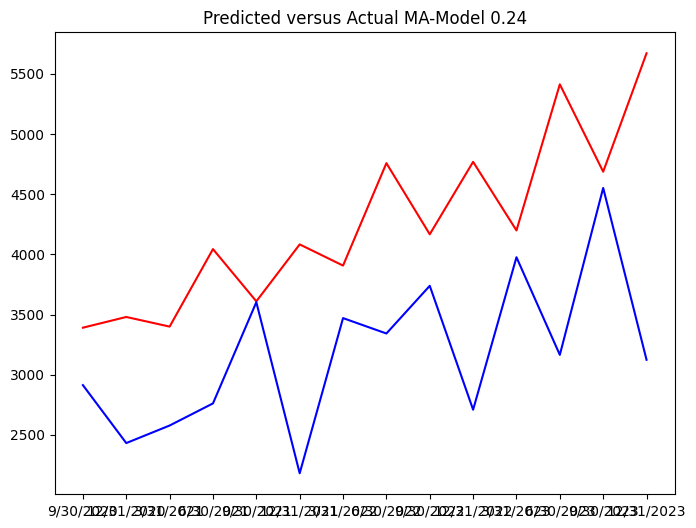

In [10]:
graph_results(df, target_variable_transformed, train_len, MA_predictions, 'MA')

### Now Finding Best MA Model

In [11]:
def find_best_ma(df, timesteps_back):

    results = []

    for i in timesteps_back:
        model = SARIMAX(df, order= (0, 0, i))
        model_fit = model.fit()
        results.append(model_fit.aic)
    
    results_df = pd.DataFrame({'Steps Back': timesteps_back,
                               'AIC': results}).sort_values(by = 'AIC', ascending=True).reset_index(drop=True)
    return results_df

# calling function
timesteps_back = range(1,10)
ma_model_compare = find_best_ma(df[target_variable_transformed], timesteps_back)
ma_model_compare.head(10)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting

,Steps Back,AIC
0,9,1030.654646
1,6,1046.614382
2,7,1048.308294
3,5,1101.076675
4,4,1110.254884
5,3,1141.128091
6,8,1149.978311
7,2,1162.646153
8,1,1242.087845


### Now Fitting Best MA Model

In [12]:
best_steps = ma_model_compare['Steps Back'][0]
best_MA_predictions = train_MA(df[target_variable_transformed], train_len, best_steps)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-

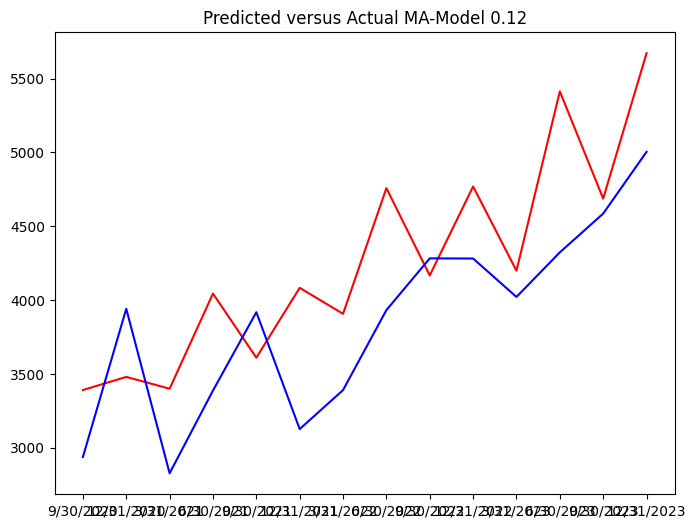

In [13]:
graph_results(df, target_variable_transformed, train_len, best_MA_predictions, 'MA')

### First Autoregressor Approach

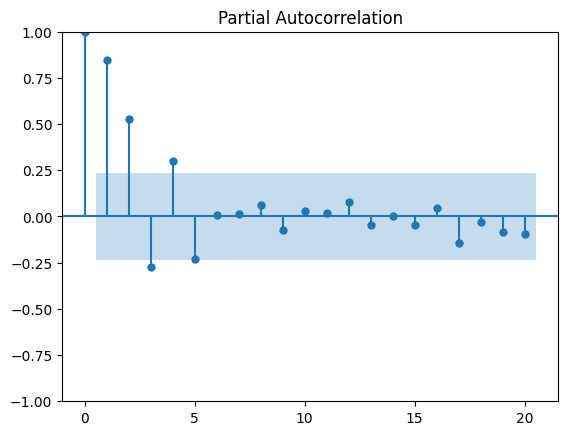

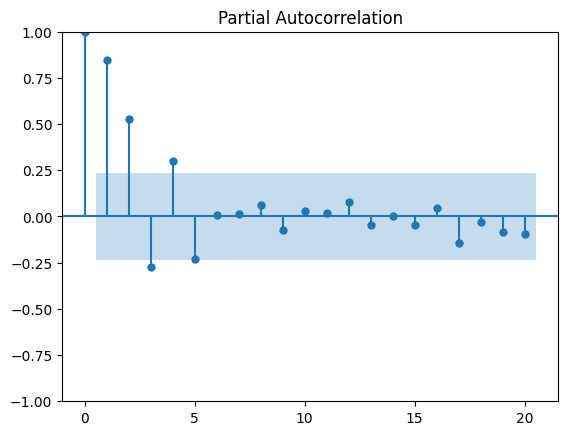

In [14]:
plot_pacf(df[target_variable_transformed].dropna(), lags= 20)

In [15]:
def train_AR(df, train_length, steps):

    # Initializing list to store predictions
    pred_AR = []
    test = df[train_length:]

    predictions = []
    for month in range(len(test)):
        model = SARIMAX(df[:train_length + month], order= (steps, 0, 0))
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_AR.append(output)

    return pred_AR

In [16]:
# Calling AR function
steps = 2
AR_predictions = train_AR(df[target_variable_transformed], train_len, steps)
print(AR_predictions)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users

[55    3493.621574
dtype: float64, 56    3751.063671
dtype: float64, 57    3402.301621
dtype: float64, 58    3448.845776
dtype: float64, 59    3548.890006
dtype: float64, 60    3924.132488
dtype: float64, 61    3715.589976
dtype: float64, 62    4028.364847
dtype: float64, 63    4103.130264
dtype: float64, 64    4602.188152
dtype: float64, 65    4301.006388
dtype: float64, 66    4625.956017
dtype: float64, 67    4434.670171
dtype: float64, 68    5242.328444
dtype: float64]


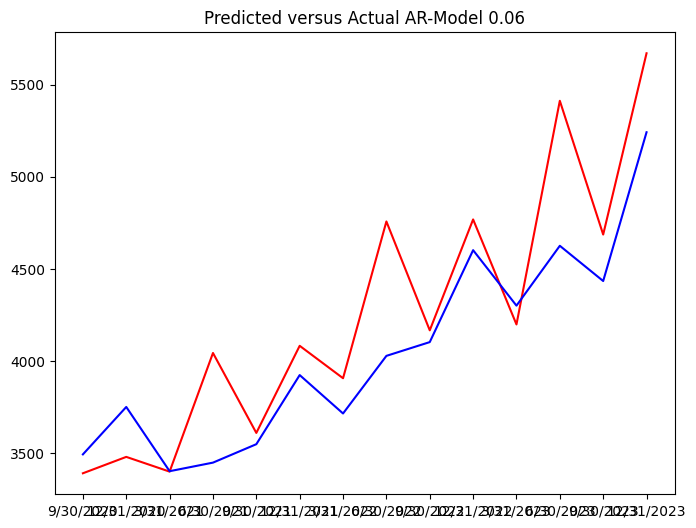

In [17]:
graph_results(df, target_variable_transformed, train_len, AR_predictions, 'AR')

In [18]:
# Finding best AR Model
def find_best_ar(df, timesteps_back):

    results = []

    for i in timesteps_back:
        model = SARIMAX(df, order= (i, 0, 0))
        model_fit = model.fit()
        results.append(model_fit.aic)
    
    results_df = pd.DataFrame({'Steps Back': timesteps_back,
                               'AIC': results}).sort_values(by = 'AIC', ascending=True).reset_index(drop=True)
    return results_df

# calling function
ar_model_compare = find_best_ar(df[target_variable_transformed], timesteps_back)
ar_model_compare.head(10)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users

,Steps Back,AIC
0,7,941.866946
1,8,942.571902
2,5,942.738517
3,9,944.326800
4,6,944.682659
5,4,977.332147
6,3,990.046232
7,2,994.858039
8,1,1056.420647


In [19]:
best_steps = ar_model_compare['Steps Back'][0]
best_AR_predictions = train_AR(df[target_variable_transformed], train_len, best_steps)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Luca

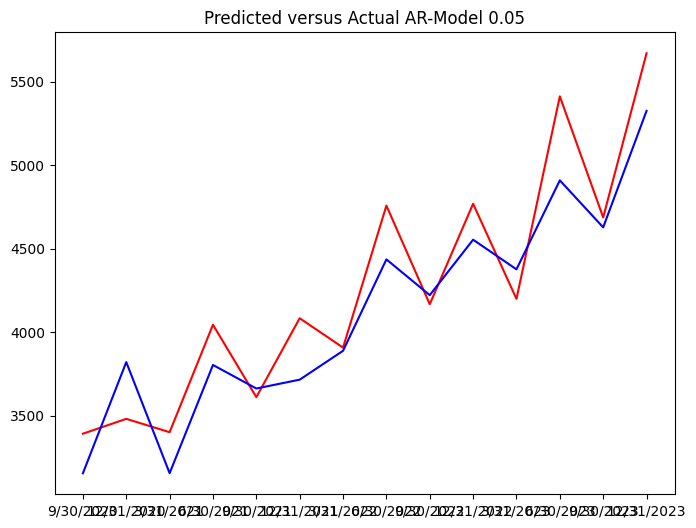

In [20]:
graph_results(df, target_variable_transformed, train_len, best_AR_predictions, 'AR')

### ARIMA Modeling Approach

In [21]:
# Defining modeling function
def optimize_ARMA(endog,  order_list):
    results = []
    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                order = (order[0], order[1], order[2]),
                simple_differencing=False).fit(disp = False)
            aic = model.aic
            results.append([order, aic])
        except:
            continue
    results_df = pd.DataFrame(results)
    results_df.columns = ['(p,d,q)', 'AIC']
    # sorting results
    results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

    return results_df

In [22]:
# normal variables
p = range(0, 4, 1)
d = range(0,1,1)
q = range(0, 4, 1)
# Combining parameters
parameters = product(p,d, q)

# Training models
results_df = optimize_ARMA(df[target_variable_transformed], parameters)

# viewing results
print(results_df.sort_values(by = ['AIC']))

2it [00:00, 18.72it/s]c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

4it [00:00,  9.91it/s]c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\U

      (p,d,q)          AIC
0   (2, 0, 3)   955.572854
1   (3, 0, 3)   957.895313
2   (3, 0, 2)   959.833414
3   (2, 0, 2)   966.823217
4   (2, 0, 1)   969.159256
5   (3, 0, 1)   971.146053
6   (3, 0, 0)   990.046232
7   (2, 0, 0)   994.858039
8   (1, 0, 2)  1008.911111
9   (1, 0, 3)  1019.141369
10  (1, 0, 1)  1026.773687
11  (1, 0, 0)  1056.420647
12  (0, 0, 3)  1141.128091
13  (0, 0, 2)  1162.646153
14  (0, 0, 1)  1242.087845
15  (0, 0, 0)  1300.899310


### Training Optimal ARIMA

In [23]:
# defining function for model training
def train_ARIMA_optimal(df,  train_length, order):

    # Initializing list to store predictions
    pred_arima = []
    predictions = []

    test = df[train_length:]

    for month in range(len(test)):
        model = SARIMAX(df[:train_len + month], 
                        order= order)
        model_fit = model.fit()
        output = model_fit.forecast()
        pred_arima.append(output)
        actual_val = list(df)[train_len + month]

    return pred_arima

# calling function and returning predictions
order = (3, 0, 2)
optimal_ARMA_predictions = train_ARIMA_optimal(df[target_variable_transformed], train_len, order)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\

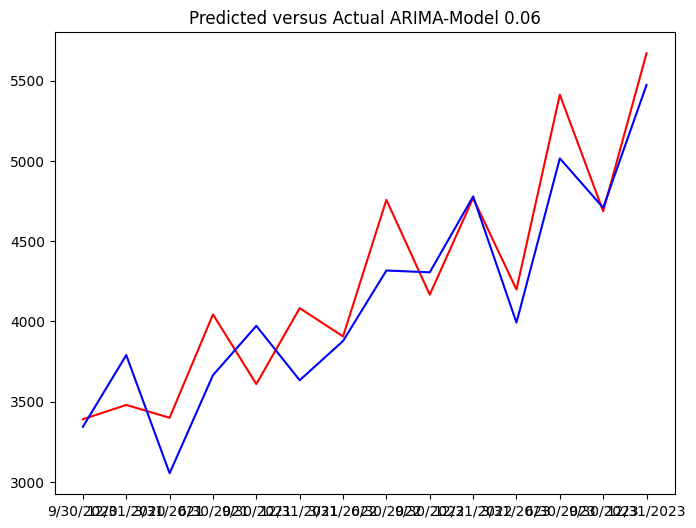

In [24]:
graph_results(df, target_variable_transformed, train_len, optimal_ARMA_predictions, 'ARIMA')

### Optimizing SARIMA

In [25]:
# Defining modeling function
def optimize_SARIMA(endog,  order_list):
    results = []
    for order in tqdm(order_list):
        try:
            
            model = SARIMAX(
                endog,
                order = (order[0], order[1], order[2]),
                seasonal_order=(order[3], order[4], order[5], 4),
                simple_differencing=False).fit(disp = False)
            aic = model.aic
            results.append([order, aic])
        except:
            continue
    results_df = pd.DataFrame(results)
    results_df.columns = ['(p,d,q)', 'AIC']
    # sorting results
    results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

    return results_df


# normal variables
p = range(0, 4, 1)
d = range(0,1,1)
q = range(0, 4, 1)
sp = range(0, 4, 1)
sd = range(0,1,1)
sq = range(0, 4, 1)
# Combining parameters
parameters = product(p,d, q, sp, sd, sq)

# Training models
results_sarima_df = optimize_SARIMA(df[target_variable_transformed], parameters)

# viewing results
print(results_sarima_df.sort_values(by = ['AIC']))

2it [00:00, 18.90it/s]c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

4it [00:00,  8.44it/s]c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.


                (p,d,q)          AIC
0    (0, 0, 3, 2, 0, 1)    14.000000
1    (0, 0, 3, 3, 0, 0)    14.000000
2    (2, 0, 1, 1, 0, 3)    16.000000
3    (0, 0, 3, 3, 0, 2)    18.000000
4    (2, 0, 3, 2, 0, 3)    22.000000
..                  ...          ...
231  (0, 0, 2, 2, 0, 1)  1245.628732
232  (0, 0, 2, 3, 0, 2)  1256.874426
233  (0, 0, 3, 3, 0, 3)  1257.035561
234  (0, 0, 2, 3, 0, 3)  1257.106895
235  (0, 0, 0, 0, 0, 0)  1300.899310

[236 rows x 2 columns]
